<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Otimiza%C3%A7%C3%A3o_Ag_pol%C3%ADtica_de_manuten%C3%A7%C3%A3o_preventiva_imperfeita_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [974]:
%%capture
pip install geneticalgorithm

In [975]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import csv
import math
from geneticalgorithm import geneticalgorithm as ga
from scipy.optimize import differential_evolution

In [976]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [977]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 10000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 1460 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 17000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

In [978]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
          # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha $\it{u(t)}$")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [979]:
class FuncaoConfiabilidade:
    # Este método vai inicializar cada objeto criado a partir desta classe
        # O nome deste método é __init__
        # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
        #
        # Atributos de cada objeto criado a partir desta classe.
        # O self indica que estes são atributos dos objetos
    def __init__(self, T, s, solucao, last_failure):
        self.reducao = 'Idade'
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T
        self.s = [[0] + s[0]]

        print('Fator de reducao:', self.reducao)

        # Função de Confiabilidade
        self.R = []
        tn = last_failure
        Tc = self.T[-1]
        c = len(self.T)

        # severidade da última MP
        severidade = self.s[-1][-1]

        # Fator da ultima MP
        fator_final = self.s[-1][-1]

        for t in range(self.sz):
            a = fator_final
            val = ((1 / (self.lamb ** self.beta)) * ((tn + t - a * Tc) ** self.beta) - ((1 / (self.lamb ** self.beta)) * ((tn - a * Tc) ** self.beta)))
            val = math.exp(-val)
            self.R.append(val)

    def plotConfiabilidade(self, fator):
        fig = plt.figure()
        plt.plot(self.R)
        plt.xlabel("Tempo $\it{t}$ (dias)")
        plt.ylabel("Confiabilidade $\it{R(t)}$")
        plt.show()

        fileName = 'Rt_' + self.reducao + str(fator)
        fig.savefig(fileName, dpi=300, bbox_inches="tight", facecolor='w', edgecolor='w')

In [980]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [981]:
# efine a função de melhoria Linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j]*theta)
        fator.append(linha)
    return fator

In [982]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - math.exp(-s[k][j]*theta))
        fator.append(linha)
    return fator

In [983]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [984]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [985]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [986]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [987]:
# Função custo de manutenção baseada severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    cmp_f = dist[s]
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US
17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US 2.000 e US
3.000, respectivamente e MC fixa em US$15.000 texto em itálico

In [988]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario02.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario03.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario04.csv.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/datasets/cenario03.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,0.7,182
1,1309,1,7,0,0.7,366
2,1778,1,7,0,0.7,547
3,0,1,0,0,0.7,731
4,0,0,0,0,1.0,912


* t: Representa os tempos de falha.
* k: Indica o índice do sistema.
* c: Representa o número de ciclos de manutenção.
* n: Indica o número de falhas em cada ciclo de manutenção preventiva.
* s: Representa a severidade das manutenções preventivas em cada sistema.
* T: Indica os tempos das manutenções preventivas.

In [989]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [990]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [991]:
# Ajusta o modelo com base nos dados lidos
def adjust_model():
    global model_adjusted
    model_adjusted = True

    varbound = np.array([[100, 150], [1, 2], [0, 1]])

    algorithm_param = {
        'max_num_iteration': 50,
        'population_size': 100,
        'mutation_probability': 0.05,
        'elit_ratio': 0.01,
        'crossover_probability': 0.75,
        'parents_portion': 0.3,
        'crossover_type': 'two_point',
        'max_iteration_without_improv': None
    }

    model = ga(
        function=objective,
        dimension=3,
        variable_type='real',
        variable_boundaries=varbound,
        algorithm_parameters=algorithm_param,
        convergence_curve=False,
        progress_bar=False
    )
    model.run()

    res = model.best_variable

    lamb = res[0]
    beta = res[1]
    theta = res[2]

    return lamb, beta, theta

In [992]:
# Variáveis Globais
model_adjusted = False

In [993]:
# Ajusta o modelo
lamb, beta, theta = adjust_model()
print(f'lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

 The best solution found:
 [149.60341997   1.00319056   0.92216043]

 Objective function:
 -0.08470798076111057
lamb: 149.60341997340242
beta: 1.003190555042283
theta: 0.922160425312447


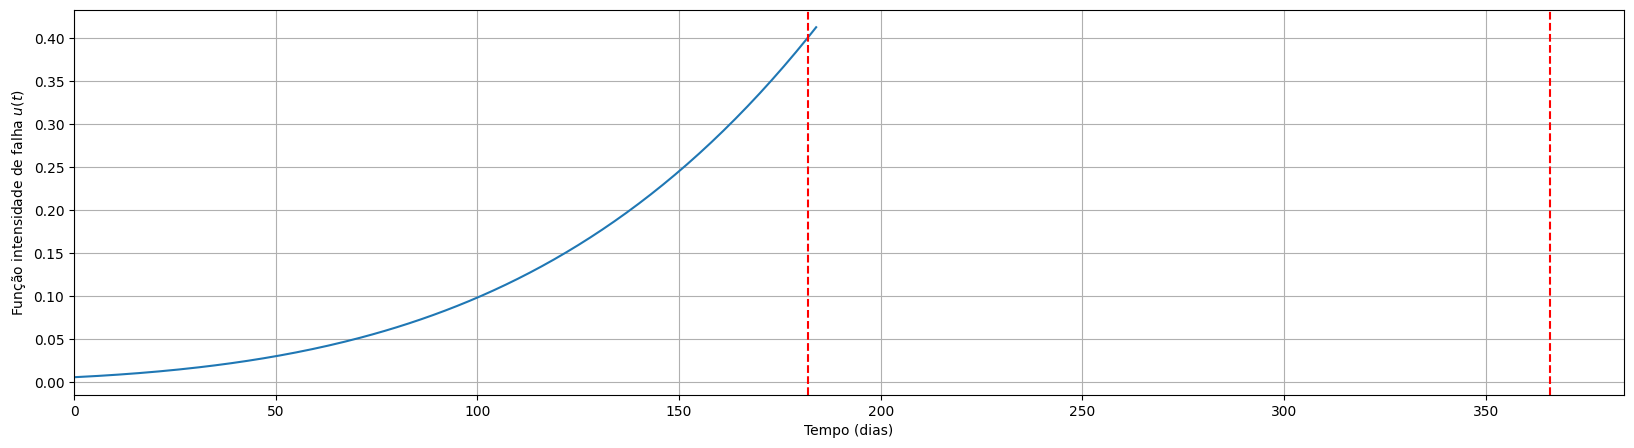

Fator ajuste:  [0.4756061724800106, 0.4756061724800106, 0.4756061724800106, 0.4756061724800106, 0.6023410001773652, 0.4756061724800106, 0.4756061724800106]


In [994]:
# Cria alguns cenários de teste
beta = beta*5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

# Etapa 2: Otimização

In [995]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo

    global s
    T = [0]
    s_row = []
    cont = 0

    for number in x:
        modulo = int(number) % 2
        if modulo == 1:
            inteiro = int(number)
            s_row.append(dict_severidades[inteiro])  # Severidade
            frac = number - inteiro  # Tempo
            t = (cont + frac) * 30
            T.append(int(t))
        cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

Aplica AG para determinar tempos e severidades



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 58, 162, 288, 371, 416, 422, 454, 505, 598, 653, 687, 701]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 1.0, 1.0, 0.5, 0.5, 1.0, 0.75, 0.25, 0.25]
Número de Sisemas: 2
Fator:  [0.4756061724800106, 0.20589541425551305, 0.36939790689957686, 0.36939790689957686, 0.4992359860888821, 0.6023410001773652, 0.6023410001773652, 0.36939790689957686, 0.36939790689957686, 0.6023410001773652, 0.4992359860888821, 0.20589541425551305, 0.20589541425551305]
Media de falhas:  [0, 0.0086271545132017, 0.5927916423822619, 14.533375503314824, 29.359073274349214, 42.70435333930736, 43.50993790743264, 46.000608314490094, 52.37533675780751, 168.06299148520807, 269.22987582036194, 282.7986226216038, 297.232493236889, 54029.81111675891]
Custo =  1300880.3024355706


Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 22, 56, 87, 251, 296, 383, 423, 503, 563, 597, 608, 717]
Severidade para cada subs

<ipython-input-995-4c7c8f851c08>:80: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 50, 71, 175, 225, 240, 309, 417, 458, 533, 591, 629, 662, 711]
Severidade para cada subsistema: [0.25, 1.0, 0.75, 0.75, 1.0, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 1.0]
Número de Sisemas: 2
Fator:  [0.4756061724800106, 0.20589541425551305, 0.6023410001773652, 0.4992359860888821, 0.4992359860888821, 0.6023410001773652, 0.20589541425551305, 0.36939790689957686, 0.36939790689957686, 0.36939790689957686, 0.20589541425551305, 0.20589541425551305, 0.36939790689957686, 0.6023410001773652]
Media de falhas:  [0, 0.0040977866799349226, 0.007012478264760794, 1.4170977838254903, 1.7208361230395453, 1.9311335207016769, 4.8435959958215005, 13.285482471871282, 56.112928212554635, 115.28326202013929, 186.15188446042214, 247.23309137411118, 407.26418383420446, 715.3511296098677, 34417.95251580363]
Custo =  1039703.8727311576


Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 71, 116, 161, 224, 24

/usr/local/lib/python3.10/dist-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


A saída de streaming foi truncada nas últimas 5000 linhas.


Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 80, 163, 266, 300, 343, 396, 541, 704]
Severidade para cada subsistema: [1.0, 1.0, 0.25, 1.0, 0.75, 0.5, 1.0, 1.0]
Número de Sisemas: 2
Fator:  [0.4756061724800106, 0.6023410001773652, 0.6023410001773652, 0.20589541425551305, 0.6023410001773652, 0.4992359860888821, 0.36939790689957686, 0.6023410001773652, 0.6023410001773652]
Media de falhas:  [0, 0.04329178968047716, 0.446870058288417, 2.2112572744089465, 2.746745867589291, 16.143641751450044, 18.77892116357668, 79.14957503002452, 459.79771136684144, 16857.526640733457]
Custo =  424042.2203471778


Número de ciclos de manutenção: 5 2
Tempos para manutenções preventivas: [0, 300, 392, 541, 645, 719]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 0.75, 1.0]
Número de Sisemas: 2
Fator:  [0.4756061724800106, 0.6023410001773652, 0.6023410001773652, 0.6023410001773652, 0.4992359860888821, 0.6023410001773

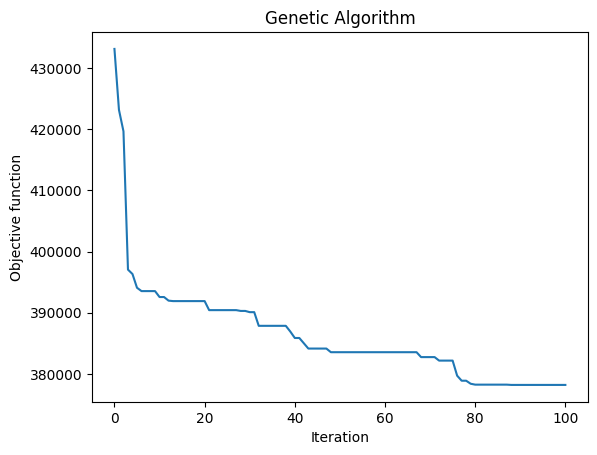

In [996]:
# Otimização da política de manutenção com AG
dimension = 24
varbound = np.array([[0, 8]] * 24)

algorithm_param_ = {
    'max_num_iteration': 100,\
    'population_size': 100,\
    'mutation_probability': 0.05,\
    'elit_ratio': 0.01,\
    'crossover_probability': 0.75,\
    'parents_portion': 0.3,\
    'crossover_type': 'two_point',\
    'max_iteration_without_improv': None
}

model_=ga(
    function = objective_st,
    dimension = dimension,
    variable_type = 'real',
    variable_boundaries = varbound,
    algorithm_parameters = algorithm_param_
)
model_.run()

In [997]:
# Coletar as melhores posições
best_positions = np.array(model_.output_dict['variable'])

# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_ag/melhor_custo_ag_quarto_cenario.csv'

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(best_positions[0])

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), best_positions[0], lamb, beta, theta, algorithm_param_['population_size'], algorithm_param_['max_num_iteration'], dimension]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor Custo', 'Lambda (λ)', 'Beta (β)', 'Theta (θ)', 'Tamanho da população', 'Numero de Interações', 'Dimensions'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)

In [998]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 149.60341997340242
beta: 5.0159527752114155
theta: 0.922160425312447


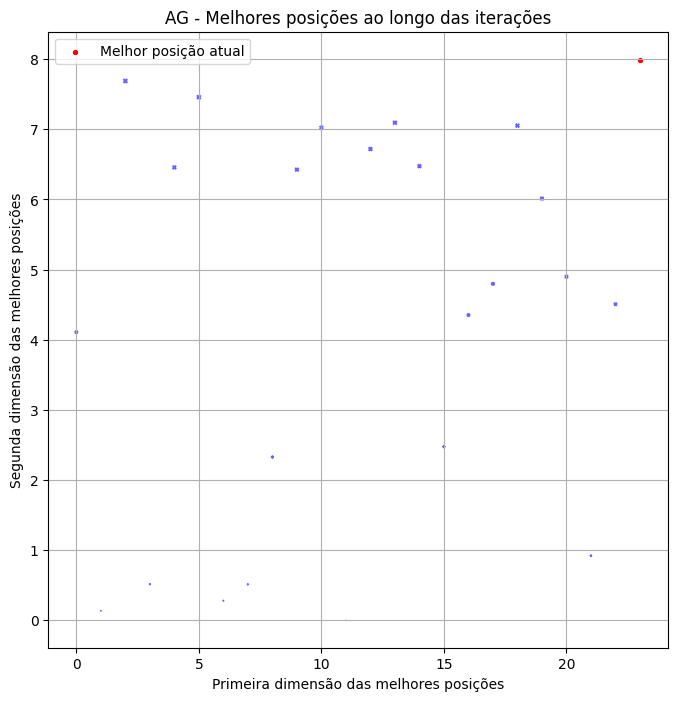


Número total de iterações: 100
Tamanho da população: 100
Número de Dimensões: 24
Melhor partícula: 7.9926805992019


In [999]:
# Plotar o gráfico 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Usar o índice das iterações como coordenada x
x = np.arange(best_positions.shape[0])

# Plotar todas as melhores posições anteriores
ax.scatter(x[:-1], best_positions[:-1], best_positions[:-1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(x[-1], best_positions[-1], best_positions[-1], c='red', label='Melhor posição atual')

ax.set_title('AG - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

print("")
print("Número total de iterações:", algorithm_param_['max_num_iteration'])
print("Tamanho da população:", algorithm_param_['population_size'])
print("Número de Dimensões:", dimension)
print("Melhor partícula:", best_positions[-1])

In [1000]:
sol = model_.best_variable

In [1001]:
# Decodifica a solução encontrada
dict = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}
T = [0]
s_row = []
cont = 0

for number in sol:
    modulo = int(number) % 2
    if modulo == 1:
        inteiro = int(number)
        s_row.append(dict[inteiro])  # Severidade
        frac = number - inteiro  # Tempo
        t = (cont + frac) * 30
        T.append(int(t))
    cont += 1

s = []
for row in range(m):
    s.append(s_row)

# A partir da solução define o número de ciclos
ck = len(T) - 1

print('Número de ciclos de manutenção:', ck)
print('Tempos para manutenções preventivas:', T)
print('Severidade para cada subsistema:', s[0])

Número de ciclos de manutenção: 6
Tempos para manutenções preventivas: [0, 80, 163, 300, 392, 541, 719]
Severidade para cada subsistema: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
